<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Required-Packages" data-toc-modified-id="Importing-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Required Packages</a></span></li><li><span><a href="#Importing-Dataset" data-toc-modified-id="Importing-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Dataset</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Stationarity" data-toc-modified-id="Stationarity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stationarity</a></span><ul class="toc-item"><li><span><a href="#Original-Series-Stationarity-Check" data-toc-modified-id="Original-Series-Stationarity-Check-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Original Series Stationarity Check</a></span></li><li><span><a href="#Transformation-Techniques" data-toc-modified-id="Transformation-Techniques-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Transformation Techniques</a></span><ul class="toc-item"><li><span><a href="#Log-Tranformation" data-toc-modified-id="Log-Tranformation-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Log Tranformation</a></span></li><li><span><a href="#Differencing" data-toc-modified-id="Differencing-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Differencing</a></span></li><li><span><a href="#Log-Transform-followed-by-Differencing" data-toc-modified-id="Log-Transform-followed-by-Differencing-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Log Transform followed by Differencing</a></span></li></ul></li></ul></li><li><span><a href="#Model-Building" data-toc-modified-id="Model-Building-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Building</a></span></li><li><span><a href="#Model-Predictions" data-toc-modified-id="Model-Predictions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Predictions</a></span><ul class="toc-item"><li><span><a href="#Train-Once---Predict-Once" data-toc-modified-id="Train-Once---Predict-Once-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Train Once - Predict Once</a></span></li><li><span><a href="#Train-Once---Rolling-Predictions" data-toc-modified-id="Train-Once---Rolling-Predictions-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Train Once - Rolling Predictions</a></span></li><li><span><a href="#Rolling-Training---Rolling-Predictions" data-toc-modified-id="Rolling-Training---Rolling-Predictions-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Rolling Training - Rolling Predictions</a></span></li></ul></li></ul></div>


# Importing Required Packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Importing Dataset


In [2]:
file_path = "data.csv"

In [3]:
df = pd.read_csv(file_path)
df = df[["Date", "Close"]]
df.Date = pd.to_datetime(df.Date)
data_backup = df.copy()
df.set_index("Date", inplace=True)

## Analyzing the dataset


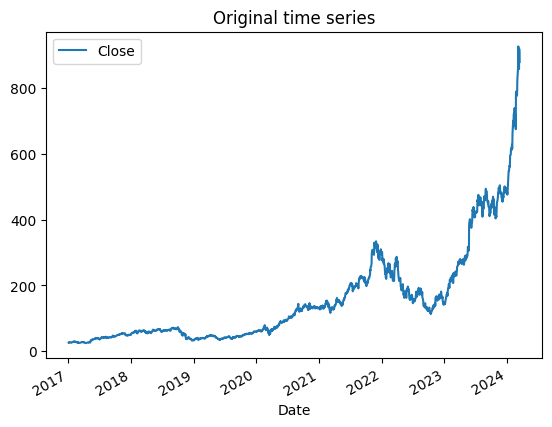

In [4]:
df.plot()
plt.title("Original time series")
plt.show()

El gráfico sugiere que no hay una estacionalidad evidente y que existe una tendencia a la alza en el precio de la acción de NVDA.
Se identifican fluctuaciones irregulares en el precio de la acción de NVDA. No es por causas aleatorias sino por la creciente demanda de GPUs para la minería de criptomonedas y entrenamiento de modelos LLM.


<Figure size 1000x600 with 0 Axes>

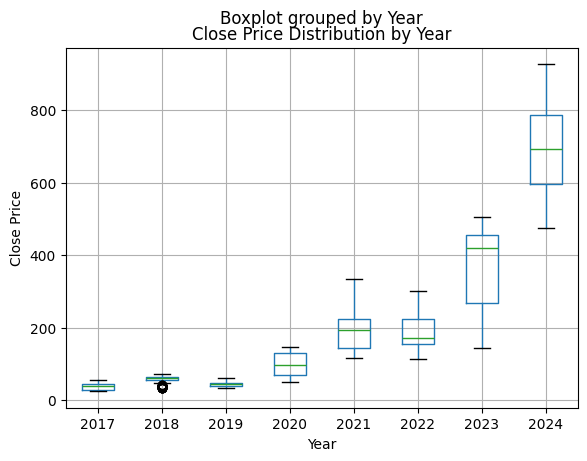

In [5]:
df["Year"] = df.index.year
plt.figure(figsize=(10, 6))
df.boxplot(column="Close", by="Year")
plt.title("Close Price Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.show()

Según el comportamiento de los boxplots, se observa que el precio de la acción de NVDA ha ido en aumento a lo largo del tiempo. Y también la varianza ha aumentado a lo largo del tiempo.


### Correlograma


# Train Test Split


In [6]:
test_size = 15
data_backup_length = len(data_backup)

In [7]:
train_df = data_backup.iloc[: data_backup_length - test_size - 1]
test_df = data_backup.iloc[(data_backup_length - test_size) :]
train_df.Date = pd.to_datetime(train_df.Date)
test_df.Date = pd.to_datetime(test_df.Date)
train_df.set_index("Date", inplace=True)
test_df.set_index("Date", inplace=True)
display(train_df.tail())

/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_93058/2035563247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date)
/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_93058/2035563247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date)


,Close
Date,
2024-02-14,739.000000
2024-02-15,726.580017
2024-02-16,726.130005
2024-02-20,694.520020
2024-02-21,674.719971


In [8]:
display(test_df.head())

,Close
Date,
2024-02-23,788.169983
2024-02-26,790.919983
2024-02-27,787.010010
2024-02-28,776.630005
2024-02-29,791.119995


# Stationarity


In this section, we check the series for its stationarity, and transform the series to stationary if it ends up being non stationary. For this a helper function is defined below that plots ACF and PACF plots of the series given to it as input.


In [9]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, zero=False, lags=40, ax=axes[0])
    sgt.plot_pacf(series, zero=False, lags=40, ax=axes[1])

    plt.show()

For checking the stationarity, we plot the **ACF** and **PACF** plots of the series, and run the **ADF** test.


## Original Series Stationarity Check


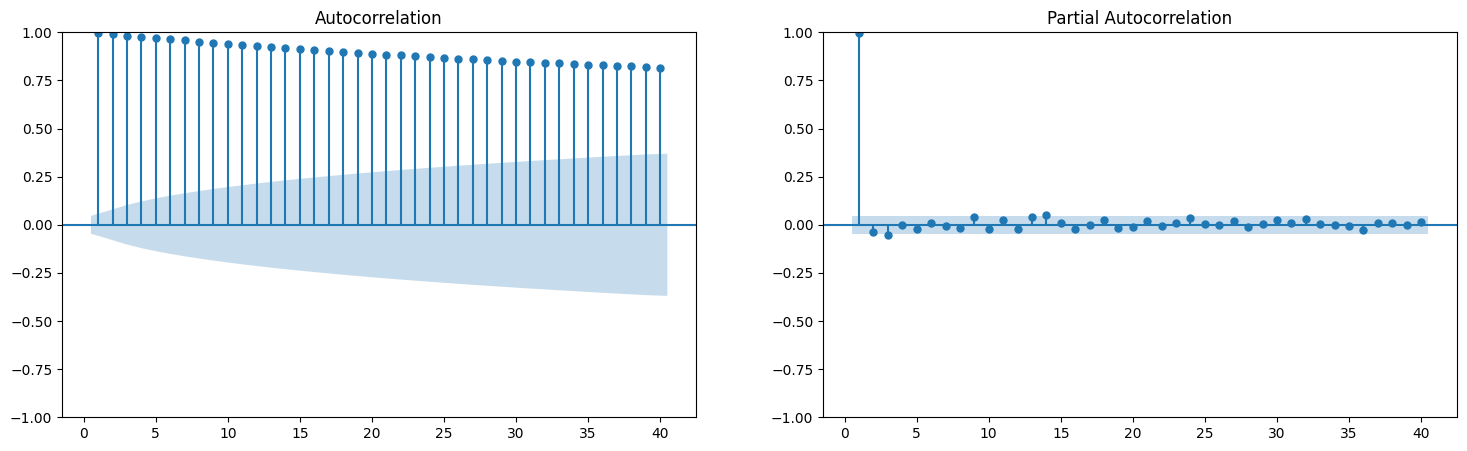

(2.151502804739108,
 0.9988401709675617,
 8,
 1786,
 {'1%': -3.43401669852096,
  '5%': -2.863159643456451,
  '10%': -2.5676322468019896},
 11318.944526177213)

In [10]:
plot_acf_pacf(train_df["Close"])
adfuller(train_df["Close"])

## Transformation Techniques


Clearly this series is **Non-Stationary**. So before applying the ARIMA Models, we tranform this series to Stationary using the following transofrmations.

- **Log Transformation**: Taking the log of each data point will dampen the effect of variance over time
- **Differencing**: Taking the difference between consecutive data points usually removes the trend changes over time.
- **Log Tranformation** followed by **Differencing**: This technique removes both mean and variance changes over time.


To see which tranformation works best for our use case, lets plot the data and its summary statistics over time.


In [11]:
def smoother(df, window=100):
    rolling_mean = df["Close"].rolling(window).mean()
    rolling_var = df["Close"].rolling(window).var()
    return rolling_mean, rolling_var

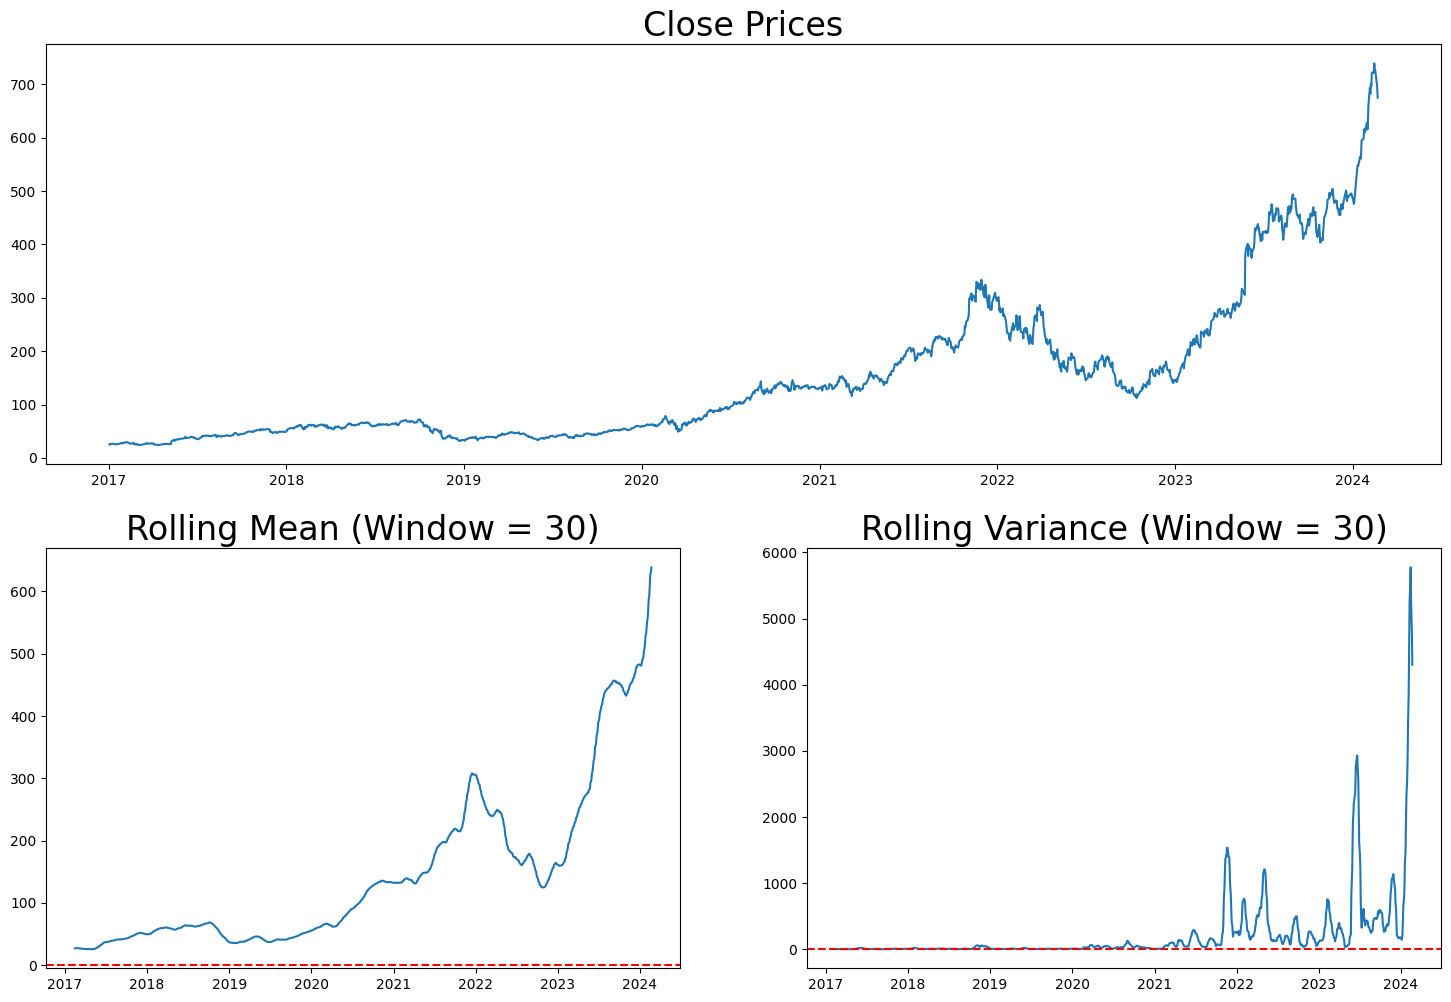

In [12]:
window_size = 30
rolling_mean, rolling_var = smoother(train_df, window_size)

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(train_df["Close"])
plt.title("Close Prices", size=24)

plt.subplot(2, 2, 3)
plt.plot(rolling_mean)
plt.axhline(y=0, color="r", linestyle="--")
plt.title(f"Rolling Mean (Window = {window_size})", size=24)

plt.subplot(2, 2, 4)
plt.plot(rolling_var)
plt.axhline(y=0, color="r", linestyle="--")
plt.title(f"Rolling Variance (Window = {window_size})", size=24)

plt.show()

From these plots its obvious that the mean and variance in the data varies with respect to time. The 3 transformation techniques listed above are applied in the following cells.


### Log Transformation


$y\_new_t = \log(y_t)$

where,

- $y\_new_t$: Transformed Series at time $t$
- $y_t$: Original Series at time $t$


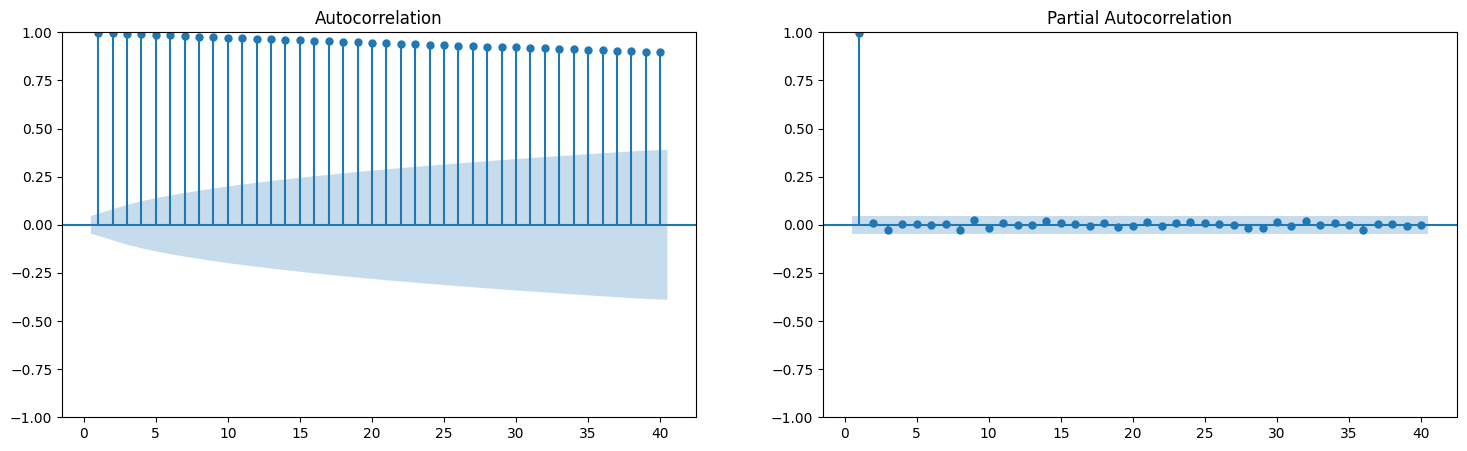

(-0.10058903652561464,
 0.949379831562543,
 9,
 1785,
 {'1%': -3.434018755659214,
  '5%': -2.8631605515716476,
  '10%': -2.5676327303470408},
 -7236.034867341657)

In [13]:
plot_acf_pacf(np.log(train_df["Close"].values))
adfuller(np.log(train_df["Close"].values))

Using the **Log Transform**, the non stationarity of the dataset could not be removed in this case.


### Differencing


$y\_new_t = y_t - y_{t-1}$

where,

- $y\_new_t$: Transformed Series at time $t$
- $y_t$: Original Series at time $t$
- $y_{t-1}$: Original Series at time $t-1$


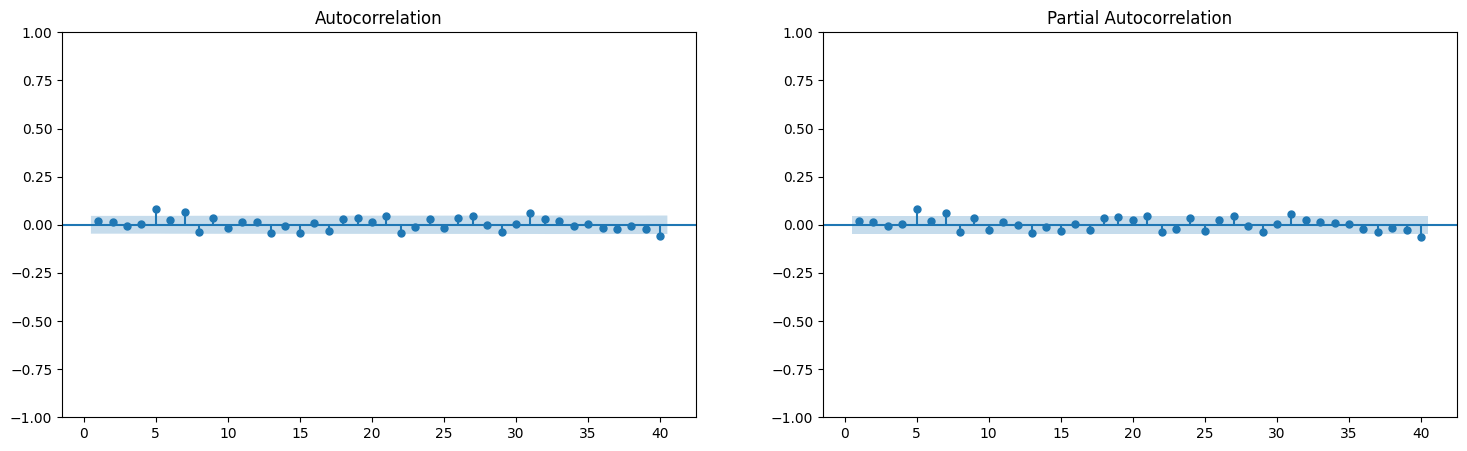

(-12.189557662123747,
 1.2951405863702862e-22,
 8,
 1785,
 {'1%': -3.434018755659214,
  '5%': -2.8631605515716476,
  '10%': -2.5676327303470408},
 11315.730512034732)

In [14]:
train_df_diff = train_df["Close"].diff(1).dropna()
plot_acf_pacf(train_df_diff)
adfuller(train_df_diff)

Clearly the series has been transformed to stationary. But since the variance of the series was also time dependent, transforming the data using **Log Transform** followed by **Differencing** seems ideal.


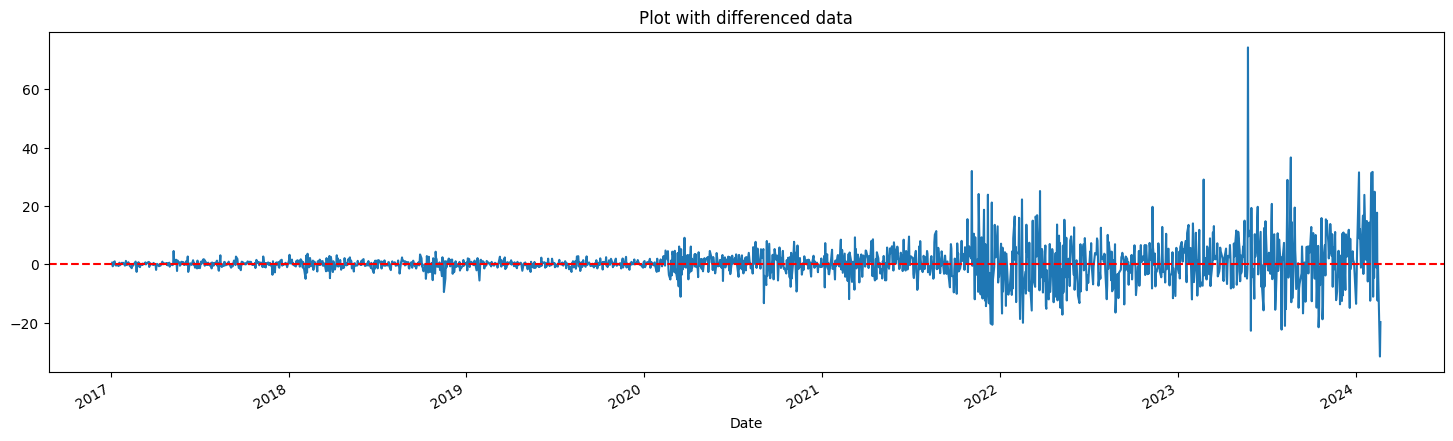

In [15]:
train_df_diff.plot()
plt.title("Plot with differenced data")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

In [16]:
train_df_diff_converted = train_df_diff.to_frame()
train_df_diff_converted

,Close
Date,
2017-01-04,0.594999
2017-01-05,-0.662500
2017-01-06,0.340000
2017-01-09,1.045000
2017-01-10,-0.202499
...,...
2024-02-14,17.719971
2024-02-15,-12.419983
2024-02-16,-0.450012


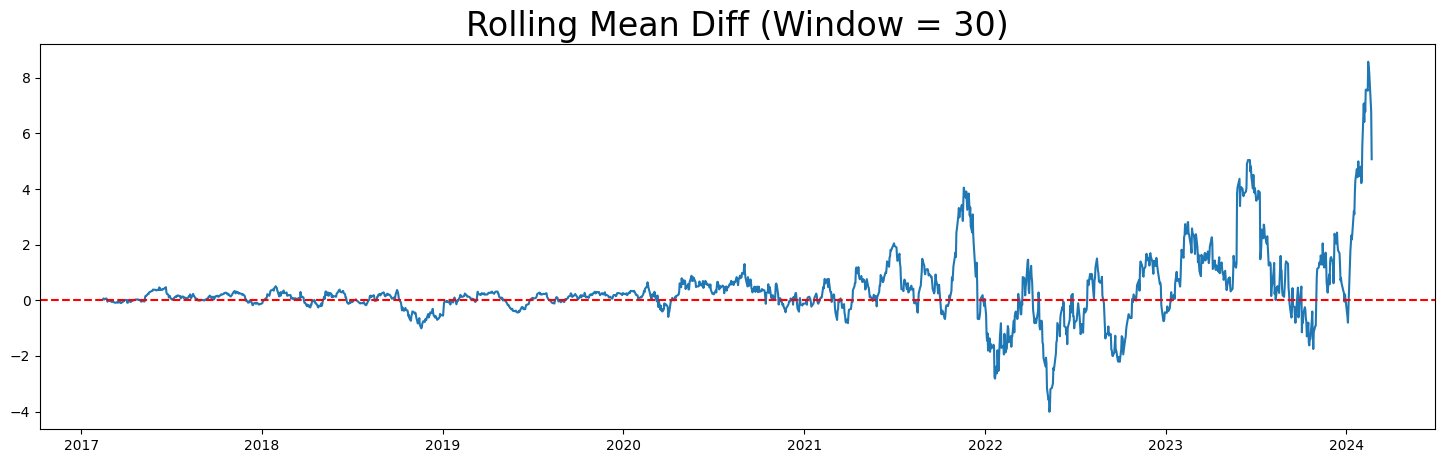

In [17]:
window_size = 30
rolling_mean_diff, rolling_var_diff = smoother(train_df_diff_converted, window_size)
plt.plot(rolling_mean_diff)
plt.title(f"Rolling Mean Diff (Window = {window_size})", size=24)
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

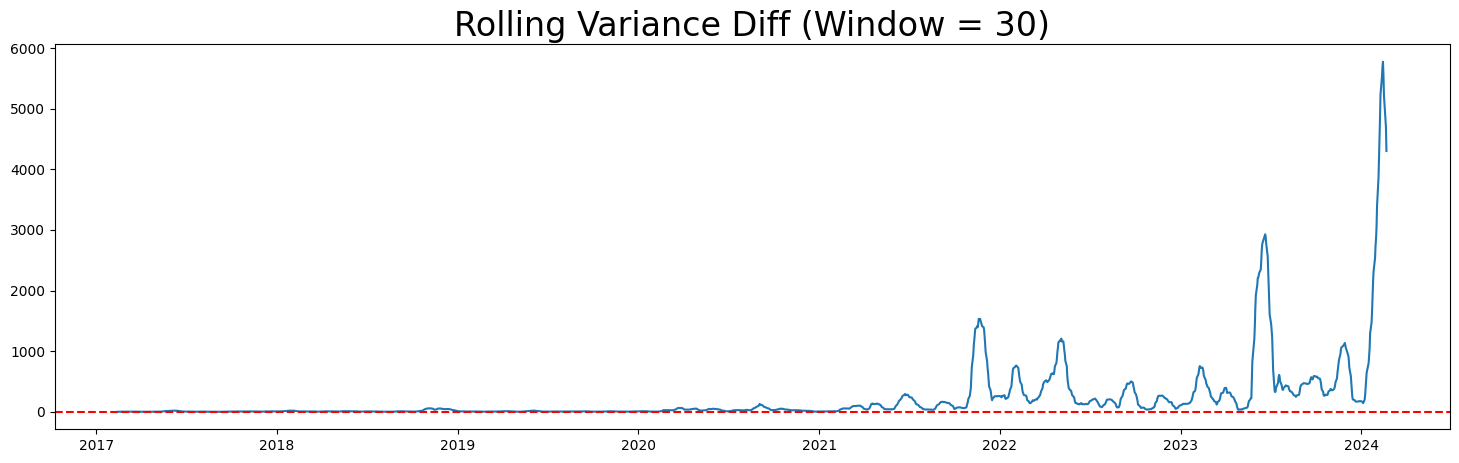

In [18]:
plt.plot(rolling_var)
plt.title(f"Rolling Variance Diff (Window = {window_size})", size=24)
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

### Log Transform followed by Differencing


$y\_LT_t = \log(y_t)$<br>
$y\_LT_{t-1} = \log(y_{t-1})$

$y\_new_t = y\_LT_t - y\_LT_{t-1}$<br>
$y\_new_t = \log(y_t) - \log(y_{t-1})$

$\therefore y\_new_t = \log(y_t / y_{t-1})$

where,

- $y\_LT_t$: Log Transformed Series at time $t$
- $y\_LT_{t-1}$: Log Transformed Series at time $t-1$
- $y\_new_t$: Final Differenced Transformed Series at time $t$
- $y_t$: Original Series at time $t$
- $y_{t-1}$: Original Series at time $t-1$


/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_93058/1453012878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Close_log_diff"] = np.log(train_df["Close"].values)
/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_93058/1453012878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Close_log_diff"] = train_df["Close_log_diff"].diff(1)


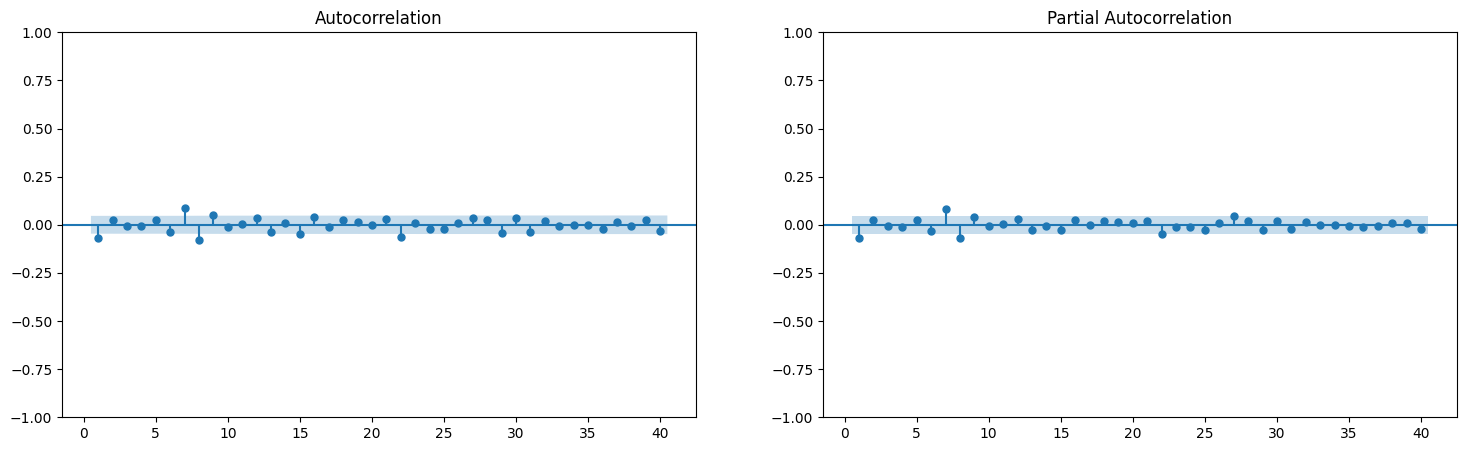

(-13.649723210983622,
 1.5943734789084765e-25,
 8,
 1785,
 {'1%': -3.434018755659214,
  '5%': -2.8631605515716476,
  '10%': -2.5676327303470408},
 -7233.4030136435995)

In [19]:
train_df["Close_log_diff"] = np.log(train_df["Close"].values)
train_df["Close_log_diff"] = train_df["Close_log_diff"].diff(1)
train_df_log_diff = train_df["Close_log_diff"].dropna()

plot_acf_pacf(train_df_log_diff)
adfuller(train_df_log_diff)

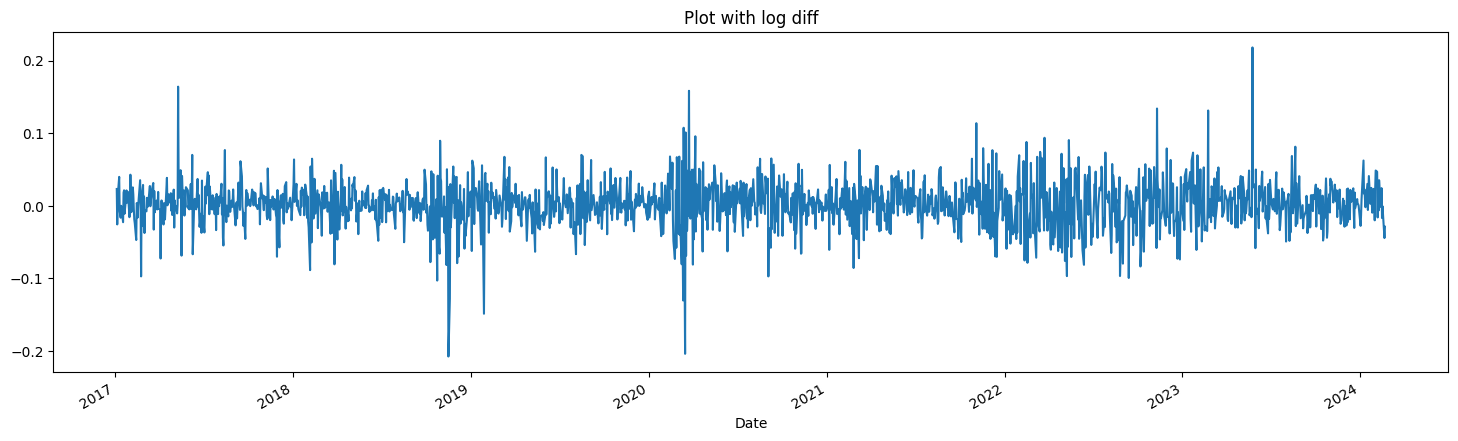

In [20]:
train_df_log_diff.plot()
plt.title("Plot with log diff")
plt.show()

In [21]:
train_df_log_diff

Date
2017-01-04    0.023063
2017-01-05   -0.025713
2017-01-06    0.013279
2017-01-09    0.039743
2017-01-10   -0.007579
                ...   
2024-02-14    0.024270
2024-02-15   -0.016949
2024-02-16   -0.000620
2024-02-20   -0.044508
2024-02-21   -0.028923
Name: Close_log_diff, Length: 1794, dtype: float64

In [22]:
train_df_log_diff_converted = train_df_log_diff.to_frame()
train_df_log_diff_converted.rename(columns={"Close_log_diff": "Close"}, inplace=True)

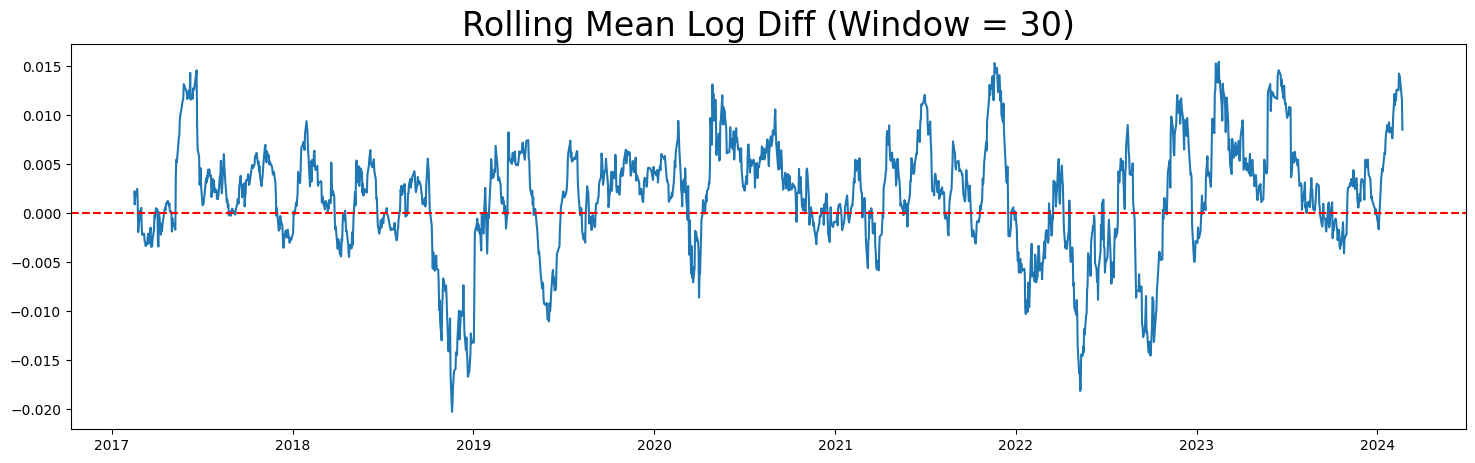

In [23]:
window_size = 30
rolling_mean_log_diff, rolling_var_log_diff = smoother(
    train_df_log_diff_converted, window_size
)
plt.plot(rolling_mean_log_diff)
plt.title(f"Rolling Mean Log Diff (Window = {window_size})", size=24)
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

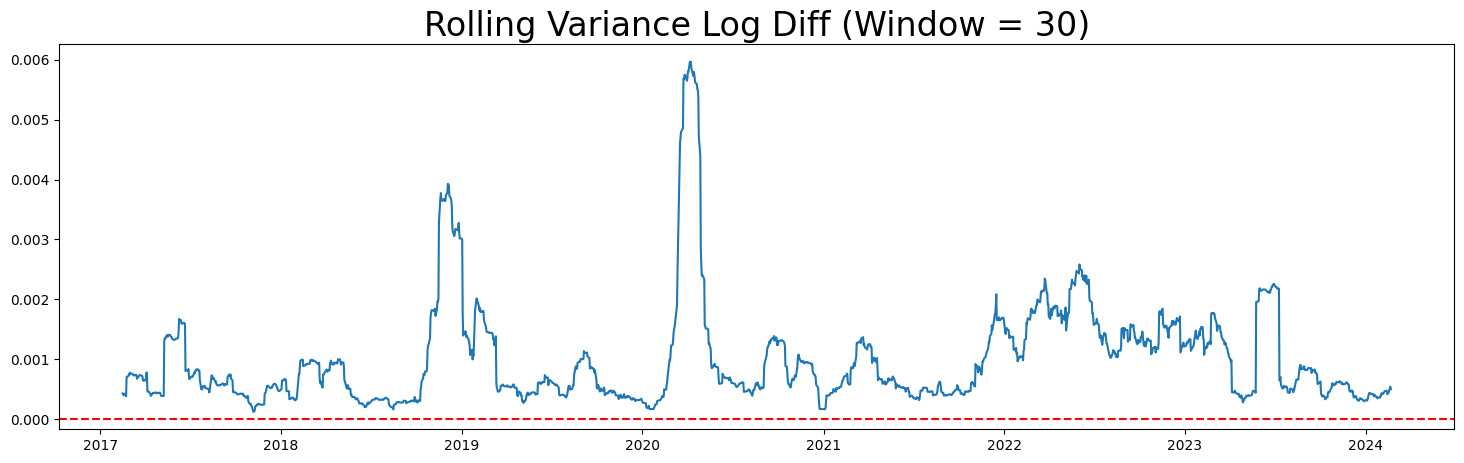

In [24]:
plt.plot(rolling_var_log_diff)
plt.title(f"Rolling Variance Log Diff (Window = {window_size})", size=24)
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

Clearly, this series is stationary and hence, it is the series that will be used to fit the model. Looking at the **ACF** and **PACF** plots for this transformed series, it is reasonalble to start building an **ARMA** Model with the following parameters -

- p = 1 or p = 2 (first 2 lags are significant in PACF plot)
- d = 0 (series is stationary)
- q = 1 or q = 2 (first 2 lags are significant in ACF plot)

If seasonal model (**SARMA**) is to be considered, then the following parameters could be added to the model.

- m = 5 (being a market index, the data is most likely to have weekly repeating patterns as seen in Visualization)
- P = 1 (5th lag is significant in PACF plot)
- D = 0
- Q = 1 (5th lag is significant in ACF plot)


# Model Building


## Naive model


In [25]:
# walk-forward validation
history = [x for x in train_df["Close"]]
predictions = list()
for i in range(len(test_df)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test_df.iloc[i].values[0]
    history.append(obs)
# report performance

values = sum(test_df.values.tolist(), [])
mape = mean_absolute_percentage_error(values, predictions)
rmse = sqrt(mean_squared_error(values, predictions))
print("Naive approach:")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

Naive approach:
RMSE: 40.95305599849104
MAPE: 0.03534156987533502


## ARIMA model (1, 1, 0)


In [26]:
def evaluate_arima_model(arima_order):
    history = np.array([x for x in train_df["Close"]])
    history = list(np.log(history))
    predictions = list()

    for i in range(len(test_df)):
        # predict
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # observation
        obs = test_df.iloc[i].values[0]
        history.append(np.log(obs))
    # report performance
    values = sum(test_df.values.tolist(), [])
    predictions = np.exp(predictions)
    mape = mean_absolute_percentage_error(values, predictions)
    rmse = sqrt(mean_squared_error(values, predictions))
    print(f"ARIMA Order: {arima_order}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    return mape, rmse

In [27]:
evaluate_arima_model((1, 1, 0))

ARIMA Order: (1, 1, 0)
RMSE: 40.87933297985346
MAPE: 0.03613826190183418


(0.03613826190183418, 40.87933297985346)

## Grid search


In [28]:
best_score, best_order = float("inf"), None
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mape, rmse = evaluate_arima_model(order)
                if mape < best_score:
                    best_score, best_order = mape, order
                print(f"ARIMA: {order} --- MAPE: {mape} --- RMSE: {rmse}")
            except:
                continue
print(f"Best ARIMA: {best_order} --- MAPE: {best_score}")

ARIMA Order: (0, 0, 0)
RMSE: 745.6707631193057
MAPE: 0.8767631803141104
ARIMA: (0, 0, 0) --- MAPE: 0.8767631803141104 --- RMSE: 745.6707631193057


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order: (0, 0, 1)
RMSE: 557.8685225172903
MAPE: 0.6550805107625111
ARIMA: (0, 0, 1) --- MAPE: 0.6550805107625111 --- RMSE: 557.8685225172903


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (0, 0, 2)
RMSE: 386.32781544584697
MAPE: 0.44804443514859976
ARIMA: (0, 0, 2) --- MAPE: 0.44804443514859976 --- RMSE: 386.32781544584697
ARIMA Order: (0, 1, 0)
RMSE: 40.95305599849104
MAPE: 0.03534156987533507
ARIMA: (0, 1, 0) --- MAPE: 0.03534156987533507 --- RMSE: 40.95305599849104


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (0, 1, 1)
RMSE: 40.82326978264104
MAPE: 0.036029500242235994
ARIMA: (0, 1, 1) --- MAPE: 0.036029500242235994 --- RMSE: 40.82326978264104


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (0, 1, 2)
RMSE: 41.25120260876013
MAPE: 0.0366328720319439
ARIMA: (0, 1, 2) --- MAPE: 0.0366328720319439 --- RMSE: 41.25120260876013
ARIMA Order: (0, 2, 0)
RMSE: 62.41686433802276
MAPE: 0.05336801544768309
ARIMA: (0, 2, 0) --- MAPE: 0.05336801544768309 --- RMSE: 62.41686433802276


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (0, 2, 1)
RMSE: 40.538218354590086
MAPE: 0.03505154320482855
ARIMA: (0, 2, 1) --- MAPE: 0.03505154320482855 --- RMSE: 40.538218354590086


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order: (0, 2, 2)
RMSE: 40.411265410587596
MAPE: 0.035769577236670846
ARIMA: (0, 2, 2) --- MAPE: 0.035769577236670846 --- RMSE: 40.411265410587596
ARIMA Order: (1, 0, 0)
RMSE: 41.01520222871158
MAPE: 0.035391414898124335
ARIMA: (1, 0, 0) --- MAPE: 0.035391414898124335 --- RMSE: 41.01520222871158


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order: (1, 0, 1)
RMSE: 40.925544370414606
MAPE: 0.03608634805510664
ARIMA: (1, 0, 1) --- MAPE: 0.03608634805510664 --- RMSE: 40.925544370414606


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order: (1, 0, 2)
RMSE: 41.329545399278
MAPE: 0.03667503155481524
ARIMA: (1, 0, 2) --- MAPE: 0.03667503155481524 --- RMSE: 41.329545399278
ARIMA Order: (1, 1, 0)
RMSE: 40.87933297985346
MAPE: 0.03613826190183418
ARIMA: (1, 1, 0) --- MAPE: 0.03613826190183418 --- RMSE: 40.87933297985346


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (1, 1, 1)
RMSE: 41.22123350034191
MAPE: 0.036505032993125956
ARIMA: (1, 1, 1) --- MAPE: 0.036505032993125956 --- RMSE: 41.22123350034191
ARIMA Order: (1, 1, 2)
RMSE: 41.26805188920645
MAPE: 0.036532810788072495
ARIMA: (1, 1, 2) --- MAPE: 0.036532810788072495 --- RMSE: 41.26805188920645


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (1, 2, 0)
RMSE: 57.980080772343634
MAPE: 0.05272881064076914
ARIMA: (1, 2, 0) --- MAPE: 0.05272881064076914 --- RMSE: 57.980080772343634
ARIMA Order: (1, 2, 1)
RMSE: 40.56313088799566
MAPE: 0.036024687535163885
ARIMA: (1, 2, 1) --- MAPE: 0.036024687535163885 --- RMSE: 40.56313088799566


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: 

ARIMA Order: (1, 2, 2)
RMSE: 40.580591198673
MAPE: 0.03499988735933781
ARIMA: (1, 2, 2) --- MAPE: 0.03499988735933781 --- RMSE: 40.580591198673


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: Convergen

ARIMA Order: (2, 0, 0)
RMSE: 40.95735937800038
MAPE: 0.036132273598480515
ARIMA: (2, 0, 0) --- MAPE: 0.036132273598480515 --- RMSE: 40.95735937800038


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (2, 0, 1)
RMSE: 40.99942463306257
MAPE: 0.03542926284397442
ARIMA: (2, 0, 1) --- MAPE: 0.03542926284397442 --- RMSE: 40.99942463306257


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (2, 0, 2)
RMSE: 40.78893766974073
MAPE: 0.0359372404864023
ARIMA: (2, 0, 2) --- MAPE: 0.0359372404864023 --- RMSE: 40.78893766974073


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (2, 1, 0)
RMSE: 41.248385338103645
MAPE: 0.03660675328397023
ARIMA: (2, 1, 0) --- MAPE: 0.03660675328397023 --- RMSE: 41.248385338103645


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Order: (2, 1, 1)
RMSE: 41.25423578211647
MAPE: 0.03659168293865632
ARIMA: (2, 1, 1) --- MAPE: 0.03659168293865632 --- RMSE: 41.25423578211647


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order: (2, 1, 2)
RMSE: 41.33646094886432
MAPE: 0.036652983879795084
ARIMA: (2, 1, 2) --- MAPE: 0.036652983879795084 --- RMSE: 41.33646094886432
ARIMA Order: (2, 2, 0)
RMSE: 50.654480471227856
MAPE: 0.04584391115403314
ARIMA: (2, 2, 0) --- MAPE: 0.04584391115403314 --- RMSE: 50.654480471227856


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

ARIMA Order: (2, 2, 1)
RMSE: 40.72176460128562
MAPE: 0.036274584141899956
ARIMA: (2, 2, 1) --- MAPE: 0.036274584141899956 --- RMSE: 40.72176460128562


/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/david/.local/share/virtualenvs/estadistica-avanzada-NMzyT9uv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order: (2, 2, 2)
RMSE: 40.08424262229448
MAPE: 0.03568847934840028
ARIMA: (2, 2, 2) --- MAPE: 0.03568847934840028 --- RMSE: 40.08424262229448
Best ARIMA: (1, 2, 2) --- MAPE: 0.03499988735933781


# Model Predictions


The predictions generated by the above model are not meaningful by themselves. The model is trained on transformed data, and thus, the predicitons are also made on the transformed data. To get meaningful predictions, we have to invert the transformation process.


**Equation for transforming the original series** (refer [this previous transformation section](#Log-Transform-followed-by-Differencing))

$y\_new_t = \log(y_t / y_{t-1})$


**Equation to invert this transformation**

$y_t = y_{t-1}e^{y\_new_t}\tag{*}$


For predicting the future data, the models built in the previous steps can be used in the following 3 ways -

- **Train Once - Predict Once**: In this, we simply forecast for the entire testing period.
- **Train Once - Rolling Predictions**: In this, we forecast for the one testing period. The new data is added for each period to predict the next period from the test set using the same model.
- **Rolling Training - Rolling Predictions**: In this, we forecast for the one testing period. The new data is added for each period to predict the next period from the test set using a newly trained model. The model is trained for each new observed point of the test set.


## Train Once - Predict Once


In this, the model is trained only once, and it is used to forecast into the entire duration of the testing set. Since the ARMA model rely on the past lags, this is a highly inefficient approach. This is because, in this approcah of forecasting, the model uses its own predictions are past lags. So, the errors are compounded and the predictions degreade over time.


Thus, referring to the euation $(*)$, $y_{t-1}$ is the predictions of the model at the previous time step.


In [29]:
# Building a predictions dataframe for this technique
pred1_df = pd.DataFrame(
    columns=[
        "Close",
        "Close_1",
        "model_preds",
        "model_preds_lower",
        "model_preds_upper",
        "model_preds_exp",
        "model_preds_lower_exp",
        "model_preds_upper_exp",
        "Close_preds",
        "Close_preds_lower",
        "Close_preds_upper",
    ],
    index=data.index,
)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred1_df["Close"] = data["Close"]
pred1_df["Close_1"] = pred1_df["Close"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred1_df["model_preds"] = model_fit.predict(
    start=train_df.index[1], end=test_df.index[-1]
)

# Getting Confidence Intervals for the transformed predictions on test set
forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred1_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower Close_log_diff"]
pred1_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper Close_log_diff"]


# Inverting the log transformation by using exponent
pred1_df["model_preds_exp"] = np.exp(pred1_df["model_preds"].values)
pred1_df["model_preds_lower_exp"] = np.exp(list(pred1_df["model_preds_lower"].values))
pred1_df["model_preds_upper_exp"] = np.exp(list(pred1_df["model_preds_upper"].values))

# Building the In Sample predictions using the formula shown in (*)
pred1_df.at[train_df.index, "Close_preds"] = (
    pred1_df.loc[train_df.index]["model_preds_exp"]
    * pred1_df.loc[train_df.index]["Close_1"]
)

# The for loop below is used to get out of sample predictions where y(t-1) are derived from predicted values
pred1_exp_list = list(pred1_df.loc[test_df.index]["model_preds_exp"].values)
y_t_1 = pred1_df.at[train_df.index[-1], "Close_preds"]
for idx, pred_exp in enumerate(pred1_exp_list):
    pred1_df.at[test_df.index[idx], "Close_preds"] = (
        pred1_df.at[test_df.index[idx], "model_preds_exp"] * y_t_1
    )
    y_t_1 = pred1_df.at[test_df.index[idx], "Close_preds"]

# Inverting the Transformation on the confidence intervals using the formula in (*)
pred1_df.at[test_df.index, "Close_preds_lower"] = (
    pred1_df.loc[test_df.index]["model_preds_lower_exp"]
    * pred1_df.loc[test_df.index]["Close_preds"]
)
pred1_df.at[test_df.index, "Close_preds_upper"] = (
    pred1_df.loc[test_df.index]["model_preds_upper_exp"]
    * pred1_df.loc[test_df.index]["Close_preds"]
)

NameError: name 'data' is not defined

Exploring the first few rows of this predictions dataframe


In [ ]:
pred1_df.head()

,spx,spx_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,spx_preds,spx_preds_lower,spx_preds_upper
Date,,,,,,,,,,,
1994-01-06,467.119995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,469.899994,467.119995,0.000000,NaN,NaN,1.000000,NaN,NaN,467.12,NaN,NaN
1994-01-10,475.269989,469.899994,-0.000363,NaN,NaN,0.999637,NaN,NaN,469.73,NaN,NaN
1994-01-11,474.130005,475.269989,-0.000896,NaN,NaN,0.999104,NaN,NaN,474.844,NaN,NaN
1994-01-12,474.170013,474.130005,-0.000294,NaN,NaN,0.999706,NaN,NaN,473.991,NaN,NaN


**Evaluating Model Performance**


- **In Sample and Out of Sample Fit**


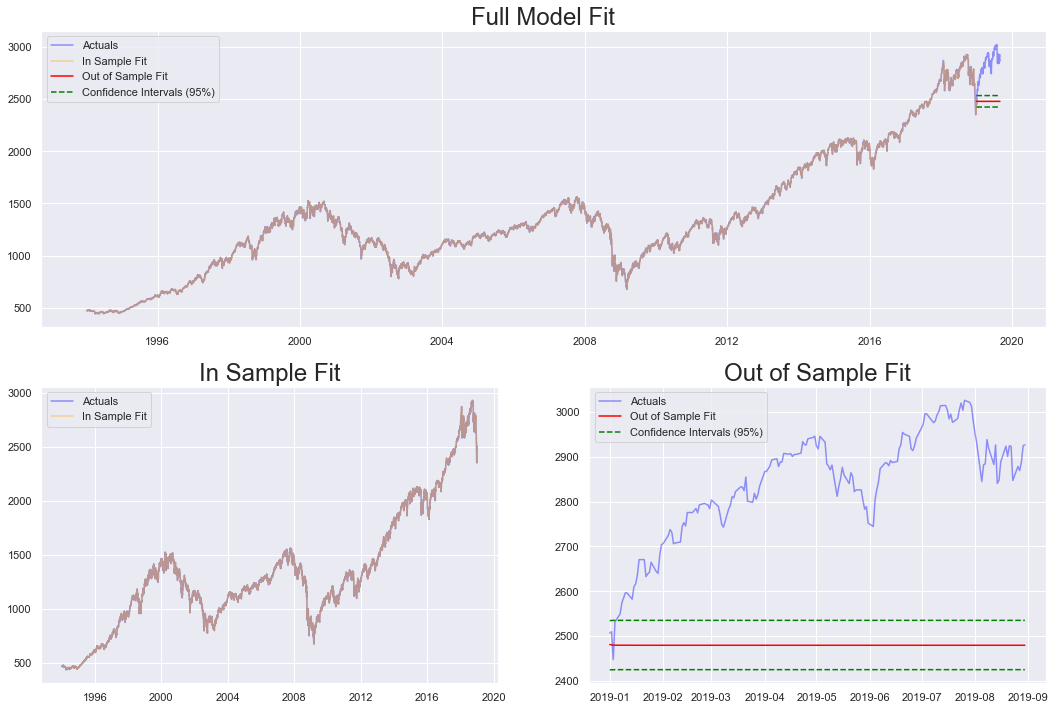

In [ ]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred1_df["Close"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred1_df.loc[train_df.index]["Close_preds"],
    color="orange",
    alpha=0.4,
    linestyle="-",
    label="In Sample Fit",
)
plt.plot(
    pred1_df.loc[test_df.index]["Close_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)
plt.plot(
    pred1_df.loc[test_df.index]["Close_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
)
plt.plot(
    pred1_df.loc[test_df.index]["Close_preds_upper"], color="green", linestyle="--"
)
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(
    pred1_df.loc[train_df.index]["Close"], color="blue", label="Actuals", alpha=0.4
)
plt.plot(
    pred1_df.loc[train_df.index]["Close_preds"],
    color="orange",
    alpha=0.4,
    linestyle="-",
    label="In Sample Fit",
)
plt.title("In Sample Fit", size=24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred1_df.loc[test_df.index]["Close"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred1_df.loc[test_df.index]["Close_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)
plt.plot(
    pred1_df.loc[test_df.index]["Close_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
)
plt.plot(
    pred1_df.loc[test_df.index]["Close_preds_upper"], color="green", linestyle="--"
)
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

- **Root Mean Squared Error**


In [ ]:
rmse_in = np.sqrt(
    mean_squared_error(
        y_true=pred1_df.loc[train_df.index[1] : train_df.index[-1]]["Close"],
        y_pred=pred1_df.loc[train_df.index[1] : train_df.index[-1]]["Close_preds"],
    )
)

rmse_out = np.sqrt(
    mean_squared_error(
        y_true=pred1_df.loc[test_df.index]["Close"],
        y_pred=pred1_df.loc[test_df.index]["Close_preds"],
    )
)

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for In Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 14.400974715921475
RMSE for In Sample Fit - 378.1531600583386


Clearly, the out of sample fit is really poor in this approach. Thus this model is not realiable for forecasting for a very long time in the future.


## Train Once - Rolling Predictions


In this, the model is trained only once, and it is used to forecast into the entire duration of the testing set. However, unlike the last approach, the previous lags for the predictions are taken from the observations in the test set itself. In practice, this means that the value forecasted for tomorrow will be derived from the actual observation made today. Since the lags are much more reliable in this case, the model will perform much better. On the other hand, this approach cannot be used to forecast for longer durations as it needs real o=past observations to build forecasts.


Thus, referring to the euation $(*)$, $y_{t-1}$ is the actual observation from the test set at the previous time step.


In [ ]:
# Building a predictions dataframe for this technique
pred2_df = pd.DataFrame(
    columns=[
        "Close",
        "Close_1",
        "model_preds",
        "model_preds_lower",
        "model_preds_upper",
        "model_preds_exp",
        "model_preds_lower_exp",
        "model_preds_upper_exp",
        "Close_preds",
        "Close_preds_lower",
        "Close_preds_upper",
    ],
    index=data.index,
)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred2_df["Close"] = data["Close"]
pred2_df["Close_1"] = pred2_df["Close"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred2_df["model_preds"] = model_fit.predict(
    start=train_df.index[1], end=test_df.index[-1]
)

# Getting Confidence Intervals for the transformed predictions on test set
forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred2_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower Close_log_diff"]
pred2_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper Close_log_diff"]


# Building the In Sample and Out of Sample predictions using the formula shown in (*)
# Taking Exponent to invert logarithmic effect
pred2_df["model_preds_exp"] = np.exp(pred2_df["model_preds"].values)
pred2_df["model_preds_lower_exp"] = np.exp(list(pred2_df["model_preds_lower"].values))
pred2_df["model_preds_upper_exp"] = np.exp(list(pred2_df["model_preds_upper"].values))

# Multiplying with past lags to get the forecast and the confidence intervals
pred2_df["Close_preds"] = pred2_df["model_preds_exp"] * pred2_df["Close_1"]
pred2_df.at[test_df.index, "Close_preds_lower"] = (
    pred2_df.loc[test_df.index]["model_preds_lower_exp"]
    * pred2_df.loc[test_df.index]["Close_1"]
)
pred2_df.at[test_df.index, "Close_preds_upper"] = (
    pred2_df.loc[test_df.index]["model_preds_upper_exp"]
    * pred2_df.loc[test_df.index]["Close_1"]
)

Exploring a few rows of this dataframe


In [ ]:
pred2_df.head()

,spx,spx_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,spx_preds,spx_preds_lower,spx_preds_upper
Date,,,,,,,,,,,
1994-01-06,467.119995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,469.899994,467.119995,0.000000,NaN,NaN,1.000000,NaN,NaN,467.119995,NaN,NaN
1994-01-10,475.269989,469.899994,-0.000363,NaN,NaN,0.999637,NaN,NaN,469.729528,NaN,NaN
1994-01-11,474.130005,475.269989,-0.000896,NaN,NaN,0.999104,NaN,NaN,474.844177,NaN,NaN
1994-01-12,474.170013,474.130005,-0.000294,NaN,NaN,0.999706,NaN,NaN,473.990819,NaN,NaN


**Evaluating Model Performance**


- **In Sample and Out of Sample Fit**


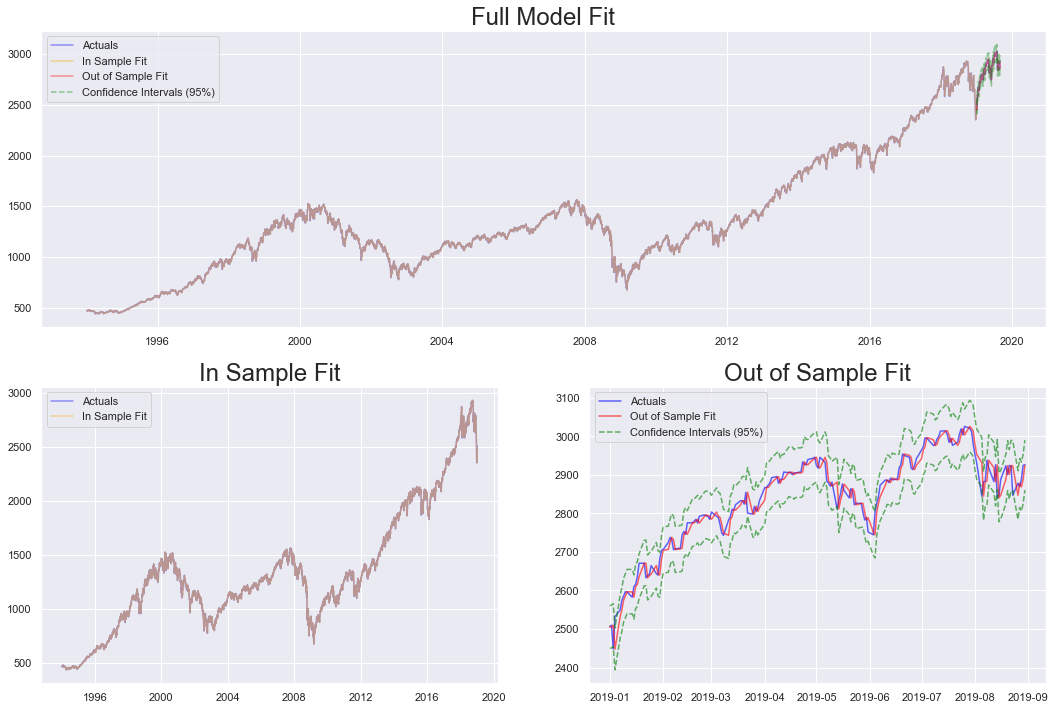

In [ ]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred2_df["Close"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred2_df.loc[train_df.index]["Close_preds"],
    color="orange",
    alpha=0.4,
    linestyle="-",
    label="In Sample Fit",
)
plt.plot(
    pred2_df.loc[test_df.index]["Close_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.4,
)
plt.plot(
    pred2_df.loc[test_df.index]["Close_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)
plt.plot(
    pred2_df.loc[test_df.index]["Close_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(
    pred2_df.loc[train_df.index]["Close"], color="blue", label="Actuals", alpha=0.4
)
plt.plot(
    pred2_df.loc[train_df.index]["Close_preds"],
    color="orange",
    linestyle="-",
    label="In Sample Fit",
    alpha=0.4,
)
plt.title("In Sample Fit", size=24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred2_df.loc[test_df.index]["Close"], color="blue", label="Actuals", alpha=0.6)
plt.plot(
    pred2_df.loc[test_df.index]["Close_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)
plt.plot(
    pred2_df.loc[test_df.index]["Close_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)
plt.plot(
    pred2_df.loc[test_df.index]["Close_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

- **Root Mean Squared Error**


In [ ]:
rmse_in = np.sqrt(
    mean_squared_error(
        y_true=pred2_df.loc[train_df.index[1] : train_df.index[-1]]["Close"],
        y_pred=pred2_df.loc[train_df.index[1] : train_df.index[-1]]["Close_preds"],
    )
)

rmse_out = np.sqrt(
    mean_squared_error(
        y_true=pred2_df.loc[test_df.index]["Close"],
        y_pred=pred2_df.loc[test_df.index]["Close_preds"],
    )
)

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for In Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 14.400974715921475
RMSE for In Sample Fit - 24.053094799484253


The **RMSE** value clearly indicate that this model is very powerful in modeliing **In sample** and **Out of Sample** Data. However, the drawback is that it needs past values for each forecast and can hence only forecast for one time step in the future.


## Rolling Training - Rolling Predictions


In this, the model is trained only once, and it is used to forecast for one lag in the future. Then the actual observation for this lag is added to the training set, the model is retrained and the new model is used to forecast for the next lag. This is the most computationaly expensive approach. However, it is the most suited to capture trend changes in the forecasting period.


Thus, referring to the euation $(*)$, $y_{t-1}$ is the actual observation from the test set at the previous time step.


The function below takes in the prediction dataframe as the input, and the indices till which the model should be trained and for which the forecasts should be made. It outputs the prediction and the confidence intervals for the corresponding forecast in the test set.


In [ ]:
def get_model(rolling_train_df, last_idx, next_i):
    train_series = rolling_train_df.loc[:last_idx]["Close"]
    train_series = np.log(train_series)
    train_series = train_series.diff(1)
    flag = 0
    while flag == 0:
        flag = 0
        try:
            rolling_model = SARIMAX(train_series.dropna(), order=(1, 0, 1))
            rolling_model_results = rolling_model.fit()
            flag = 1
        except:
            flag = 0

    rolling_pred = rolling_model_results.predict(
        start=test_df.index[next_i], end=test_df.index[next_i]
    )

    rolling_forecast = rolling_model_results.get_forecast(1)
    rolling_forecast_df = rolling_forecast.conf_int(
        alpha=0.05
    )  # Confidence level of 95%

    y_t_pred = (
        np.exp(rolling_pred.values[0])
        * rolling_train_df.at[test_df.index[next_i], "Close_1"]
    )
    y_t_pred_lower = (
        np.exp(rolling_forecast_df["lower Close"].values[0])
        * rolling_train_df.at[test_df.index[next_i], "Close_1"]
    )
    y_t_pred_upper = (
        np.exp(rolling_forecast_df["upper Close"].values[0])
        * rolling_train_df.at[test_df.index[next_i], "Close_1"]
    )

    return rolling_model_results, y_t_pred, y_t_pred_lower, y_t_pred_upper

In [ ]:
# Building a predictions dataframe for this technique
pred3_df = pd.DataFrame(
    columns=[
        "Close",
        "Close_1",
        "model_preds",
        "model_preds_lower",
        "model_preds_upper",
        "model_preds_exp",
        "model_preds_lower_exp",
        "model_preds_upper_exp",
        "Close_preds",
        "Close_preds_lower",
        "Close_preds_upper",
    ],
    index=data.index,
)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred3_df["Close"] = data["Close"]
pred3_df["Close_1"] = pred3_df["Close"].shift(1)

# Predictions on transformed data over the full training dataset and the first lag of the test dataset.
pred3_df["model_preds"] = model_fit.predict(
    start=train_df.index[1], end=test_df.index[0]
)

# Taking Exponent to invert logarithmic effect from predictions
pred3_df["model_preds_exp"] = np.exp(pred3_df["model_preds"].values)

# Building the In Sample Predictions
pred3_df.at[train_df.index, "Close_preds"] = (
    pred3_df.loc[train_df.index]["model_preds_exp"]
    * pred3_df.loc[train_df.index]["Close_1"]
)
# pred3_df.at[train_df.index, "Close_preds"] = pred3_df.loc[train_df.index]["model_preds_exp"] * pred3_df.loc[train_df.index]["Close_1"]

# The prediction for the first testing lag is built here
last_train_idx = train_df.index[-1]
rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(
    pred3_df, last_train_idx, 0
)
pred3_df.at[test_df.index[0], "Close_preds"] = y_t_pred
pred3_df.at[test_df.index[0], "Close_preds_lower"] = y_t_pred_lower
pred3_df.at[test_df.index[0], "Close_preds_upper"] = y_t_pred_upper

# This loop is used to get new models for each new lag that is added to the training set from the testing set.
for idx in range(len(test_df.index) - 1):
    last_train_idx = test_df.index[idx]
    rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(
        pred3_df, last_train_idx, idx + 1
    )
    pred3_df.at[test_df.index[idx + 1], "Close_preds"] = y_t_pred
    pred3_df.at[test_df.index[idx + 1], "Close_preds_lower"] = y_t_pred_lower
    pred3_df.at[test_df.index[idx + 1], "Close_preds_upper"] = y_t_pred_upper

In [ ]:
pred3_df.at[train_df.index, "Close_preds"] = (
    pred3_df.loc[train_df.index]["model_preds_exp"]
    * pred3_df.loc[train_df.index]["Close_1"]
)

Exploring the first few rows of this dataframe


In [ ]:
pred3_df.head()

,spx,spx_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,spx_preds,spx_preds_lower,spx_preds_upper
Date,,,,,,,,,,,
1994-01-06,467.119995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,469.899994,467.119995,0.000000,NaN,NaN,1.000000,NaN,NaN,467.12,NaN,NaN
1994-01-10,475.269989,469.899994,-0.000363,NaN,NaN,0.999637,NaN,NaN,469.73,NaN,NaN
1994-01-11,474.130005,475.269989,-0.000896,NaN,NaN,0.999104,NaN,NaN,474.844,NaN,NaN
1994-01-12,474.170013,474.130005,-0.000294,NaN,NaN,0.999706,NaN,NaN,473.991,NaN,NaN


**Evaluating Model Performance**


- **In Sample and Out of Sample Fit**


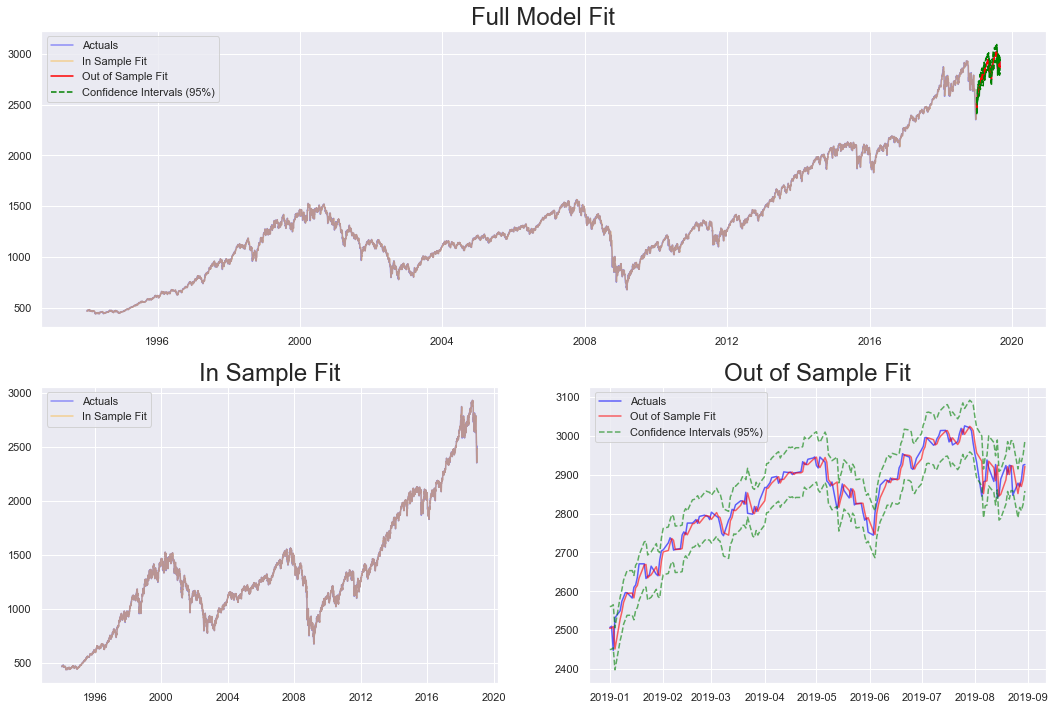

In [ ]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred3_df["Close"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred3_df.loc[train_df.index]["Close_preds"],
    color="orange",
    alpha=0.4,
    linestyle="-",
    label="In Sample Fit",
)
plt.plot(
    pred3_df.loc[test_df.index]["Close_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)
plt.plot(
    pred3_df.loc[test_df.index]["Close_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
)
plt.plot(
    pred3_df.loc[test_df.index]["Close_preds_upper"], color="green", linestyle="--"
)
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(
    pred3_df.loc[train_df.index]["Close"], color="blue", label="Actuals", alpha=0.4
)
plt.plot(
    pred3_df.loc[train_df.index]["Close_preds"],
    color="orange",
    linestyle="-",
    label="In Sample Fit",
    alpha=0.4,
)
plt.title("In Sample Fit", size=24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred3_df.loc[test_df.index]["Close"], color="blue", label="Actuals", alpha=0.6)
plt.plot(
    pred3_df.loc[test_df.index]["Close_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)
plt.plot(
    pred3_df.loc[test_df.index]["Close_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)
plt.plot(
    pred3_df.loc[test_df.index]["Close_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

- **Root Mean Squared Error**


In [ ]:
rmse_in = np.sqrt(
    mean_squared_error(
        y_true=pred3_df.loc[train_df.index[1] : train_df.index[-1]]["Close"],
        y_pred=pred3_df.loc[train_df.index[1] : train_df.index[-1]]["Close_preds"],
    )
)

rmse_out = np.sqrt(
    mean_squared_error(
        y_true=pred3_df.loc[test_df.index]["Close"],
        y_pred=pred3_df.loc[test_df.index]["Close_preds"],
    )
)

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for In Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 14.400974715921475
RMSE for In Sample Fit - 23.97736346969371


This approach clearly outperforms the other 2. However, the time spent on forecasting is much higher than that spent in the previous method, and the **RMSE** value of the 2 approches are very similar. Thus, it makes more sense to forecast using the previous approach (especially when there are no major trend changes).
